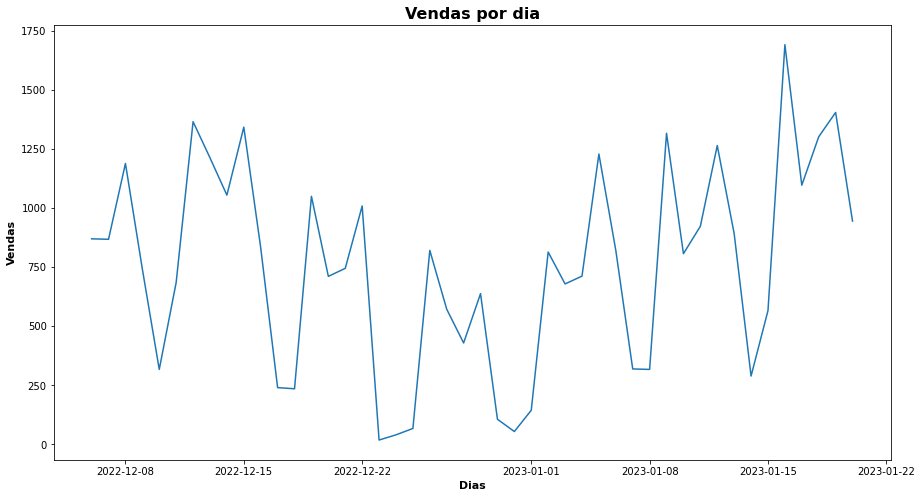

In [150]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import xgboost as xgb
from prophet import Prophet
from sklearn.metrics import mean_squared_error

dados = pd.read_excel('Dados.xlsx')
dados = dados.set_index('Data')
dados.index = pd.to_datetime(dados.index)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(dados.index,dados['Vendas'])
ax.set_title('Vendas por dia', fontsize=16, fontweight='bold')
ax.set_xlabel('Dias', fontsize=11, fontweight='bold')
ax.set_ylabel('Vendas',fontsize=11, fontweight='bold')
plt.show()

## Caracterização dos dados


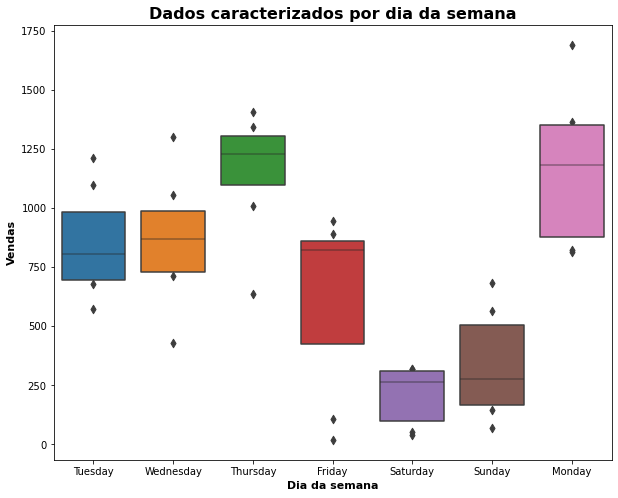

,Vendas,Semana,Dia_da_semana
Data,,,
2022-12-06,870.0,49,2
2022-12-07,868.0,49,3
2022-12-08,1189.0,49,4
2022-12-09,742.0,49,5
2022-12-10,317.0,49,6


In [151]:

def caracterizacao_dos_dados(dados: pd.DataFrame)-> pd.DataFrame:
    dados_caracterizados = dados.copy()
    dados_caracterizados['Semana'] = dados.index.isocalendar()['week'].astype('int64')
    dados_caracterizados['Dia_da_semana'] = dados.index.isocalendar()['day'].astype('int64')
    return dados_caracterizados

dados_caracterizados = caracterizacao_dos_dados(dados)

dados_caracterizados_para_gratico = dados_caracterizados.copy()
dados_caracterizados_para_gratico['Nome_dia_da_semana'] = dados_caracterizados.index.day_name()


fig, ax = plt.subplots(figsize=(10,8))
sns.boxenplot(data = dados_caracterizados_para_gratico, x = 'Nome_dia_da_semana', y = 'Vendas')
ax.set_title('Dados caracterizados por dia da semana', fontsize=16, fontweight='bold')
ax.set_xlabel('Dia da semana', fontsize=11, fontweight='bold')
ax.set_ylabel('Vendas',fontsize=11, fontweight='bold')
plt.show()
display(dados_caracterizados.head())


## Método 1: XGBoost

In [152]:
features = dados_caracterizados.columns.to_list()
target = 'Vendas'

last_index_trainning_data = math.floor(dados.shape[0] * 0.8)
first_index_test_data = last_index_trainning_data + 1

trainning_data = dados.iloc[:last_index_trainning_data]
testing_data = dados.iloc[first_index_test_data:]

train = caracterizacao_dos_dados(trainning_data)
test = caracterizacao_dos_dados(testing_data)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

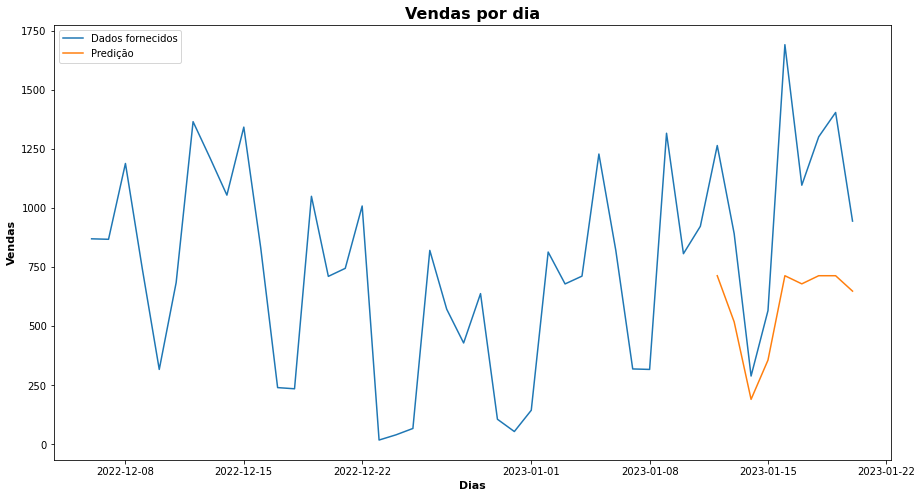

In [153]:

regressor = xgb.XGBRegressor(base_score = 0.5,
                            booster = "gbtree",
                            early_stopping_rounds = 100,
                            objective='reg:squarederror',
                            max_depth=4,
                            learning_rate=0.01)


regressor.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)

test['prediction'] = regressor.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(dados.index,dados['Vendas'], label = 'Dados fornecidos')
ax.plot(test.index, test['prediction'], label ='Predição')
ax.legend(loc="upper left")
ax.set_title('Vendas por dia', fontsize=16, fontweight='bold')
ax.set_xlabel('Dias', fontsize=11, fontweight='bold')
ax.set_ylabel('Vendas',fontsize=11, fontweight='bold')
plt.show()

#### Comentários do método 1: XGBoost
Ao avaliar uma parte dos dados como de treinamento (80%) e a outra como teste (20%) podemos observar que os dados da previsão estão mais próximos da realidade nos momentos de vale da serie temporal, porém nos momentos de crista a previsão não fica próximo da realidade.

## Método 2: Facebook Prophet

In [154]:
features = dados_caracterizados.columns.to_list()
target = 'Vendas'

last_index_trainning_data = math.floor(dados.shape[0] * 0.8)
first_index_test_data = last_index_trainning_data + 1

trainning_data = dados.iloc[:last_index_trainning_data]
testing_data = dados.iloc[first_index_test_data:]


trainning_data_prophetic = trainning_data.reset_index().rename(columns= {
                                                                        "Data": "ds",
                                                                        "Vendas": "y"})

testing_data_prophetic = testing_data.reset_index().rename(columns={
                                                                    "Data": "ds",
                                                                    "Vendas": "y"})


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


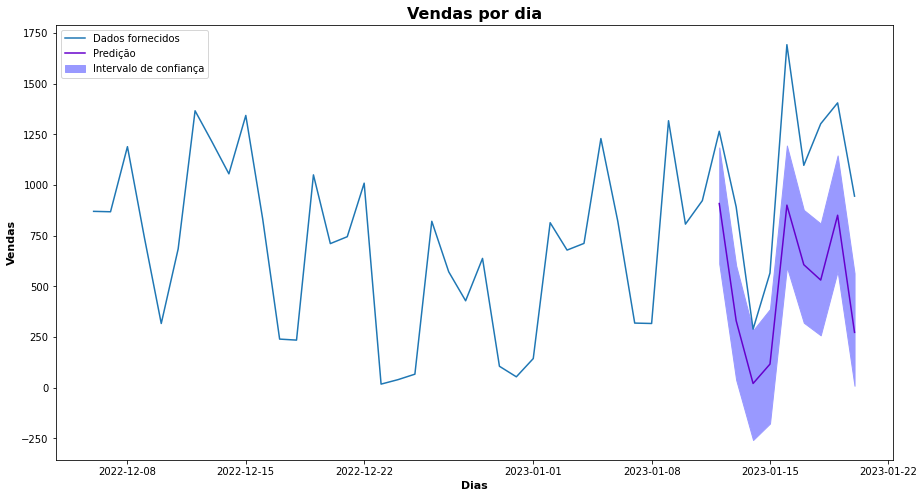

In [155]:
prophetic_model = Prophet()
prophetic_model.fit(trainning_data_prophetic)
prediction = prophetic_model.predict(testing_data_prophetic)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(dados.index,dados['Vendas'], label = 'Dados fornecidos')
ax.plot(prediction['ds'], prediction['yhat'], color='#6600cc',label ='Predição')
ax.fill_between(prediction['ds'], prediction['yhat_lower'], prediction['yhat_upper'], color="#9999ff", label = 'Intervalo de confiança')
ax.legend(loc="upper left")
ax.set_title('Vendas por dia', fontsize=16, fontweight='bold')
ax.set_xlabel('Dias', fontsize=11, fontweight='bold')
ax.set_ylabel('Vendas',fontsize=11, fontweight='bold')
plt.show()


#### Comentários do método 2: Facebook Prophet

Para o segundo método, o gráfico da predição tende a seguir o mesmo formato do gráfico dos dados fornecidos, mas ainda com um distanciamento da realidade. Além disso, dentro do intervalo de confiaça, o limete superior foi o que mais se aproximou dos dados reais


## Método escolhido para a previsão de 5 dias 

Como pelo Facebook Prophet a forma do gráfico é mais próxima da realidade seja em momentos de vale ou de crista ele será usado para fazer a predição de 5 dias

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


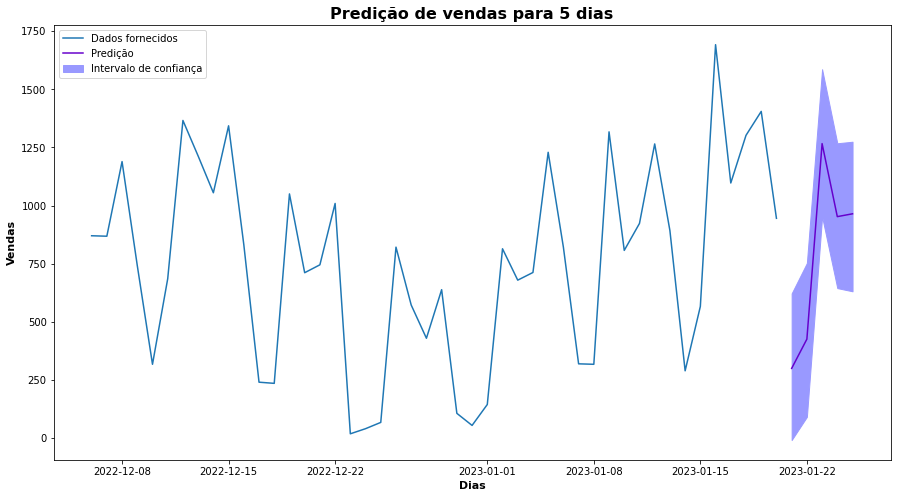

In [156]:
data_available = dados.reset_index().rename(columns= {
                                                      "Data": "ds",
                                                      "Vendas": "y"})

chosen_model = Prophet()
chosen_model.fit(data_available)

days_to_forcast = chosen_model.make_future_dataframe(periods=5, include_history= False)
forcasting = chosen_model.predict(days_to_forcast)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(dados.index,dados['Vendas'], label = 'Dados fornecidos')
ax.plot(forcasting['ds'], forcasting['yhat'], color='#6600cc',label ='Predição')
ax.fill_between(forcasting['ds'], forcasting['yhat_lower'], forcasting['yhat_upper'], color="#9999ff", label = 'Intervalo de confiança')
ax.legend(loc="upper left")
ax.set_title('Predição de vendas para 5 dias', fontsize=16, fontweight='bold')
ax.set_xlabel('Dias', fontsize=11, fontweight='bold')
ax.set_ylabel('Vendas',fontsize=11, fontweight='bold')
plt.show()